<a href="https://colab.research.google.com/github/tsheltonking/Transfer-Learning-For-Pneumonia-Detection/blob/master/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Summary

>Retrain the inception v3 image classifier on pneumonia dataset using Tensorflow+Keras. Show the training process as well as two examples of it making predictions on images from the testing dataset.

# Fetching Data & Dependencies

In [62]:
import os, json, keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing import image

Tensorflow version 1.14.0


> Download the dataset manually [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/data) or see instructions on how to get your [Kaggle API Token](https://github.com/Kaggle/kaggle-api) and add the resulting `.json` to your project directory before running the following:

In [0]:
# Fetches the dataset.
with open('kaggle.json') as f:
    d = json.load(f)
os.environ['KAGGLE_USERNAME'] = d["username"]
os.environ['KAGGLE_KEY'] = d["key"]

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
os.remove('chest-xray-pneumonia.zip')

In [0]:
# Set Paths Here
train_dir = "chest_xray/train"
val_dir = "chest_xray/val"
test_dir = "chest_xray/test"

## Helper Functions

In [0]:
def plot_images(path="test", kind="normal", num=6):  
  plt.figure(figsize=(15, 8))
  full_path = "chest_xray/" + path + '/' + kind
  i=0
  for file in os.listdir(full_path):
    if file.endswith(".jpeg"):
      if i >= num:
          break
  
      img = mpimg.imread(full_path+"/"+file)
      plt.subplot(231+i)
      plt.title(file.split('.')[0])
      imgplot = plt.imshow(img)
      i=i+1

In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Visualizing the Dataset

> Let's compare some of the images from each category.


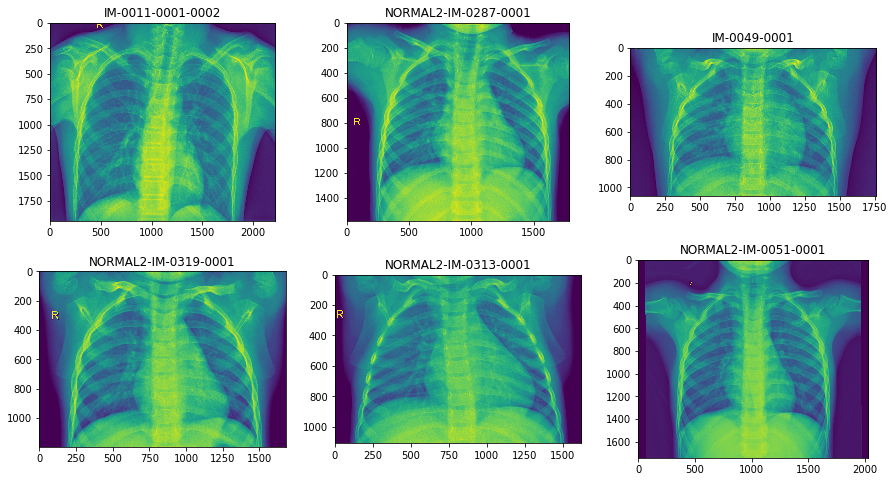

In [69]:
plot_images("test", "NORMAL", 6)

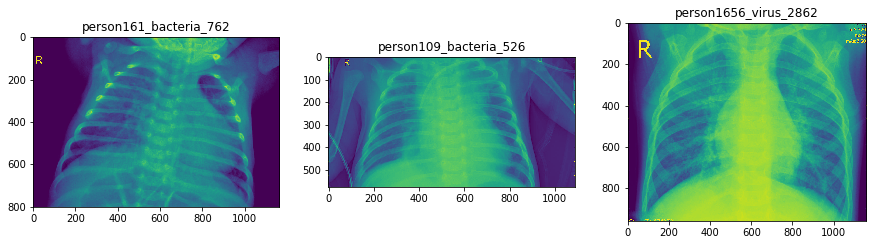

In [61]:
plot_images("test", "PNEUMONIA", 3)

# Data Preprocessing

In [0]:
# Add the InceptionV3 image classifier model with top layer removed.
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)

In [0]:
for layer in base_model.layers:
  layer.trainable = False
  
model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

In [78]:
batch_size = 200
data_gen = ImageDataGenerator(rescale=1/255.)

train_generator = data_gen.flow_from_directory(train_dir, target_size=(150,150), batch_size=batch_size, class_mode="categorical")
valid_generator = data_gen.flow_from_directory(val_dir, target_size=(150,150), batch_size=batch_size, class_mode="categorical")
test_generator = data_gen.flow_from_directory(test_dir, target_size=(150,150), batch_size=batch_size, class_mode="categorical")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Modeling

In [79]:
model.compile(loss ="categorical_crossentropy", optimizer = "adam",metrics=["accuracy"])

fit_history = model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch=len(train_generator),
        epochs=5,
        validation_data=valid_generator, #validation data generator 
        validation_steps=len(valid_generator))

Epoch 1/5
27/27 [==============================] - 66s 2s/step - loss: 0.6738 - acc: 0.8322 - val_loss: 5.3559 - val_acc: 0.5000
Epoch 2/5
27/27 [==============================] - 56s 2s/step - loss: 0.1906 - acc: 0.9323 - val_loss: 1.0673 - val_acc: 0.5625
Epoch 3/5
27/27 [==============================] - 58s 2s/step - loss: 0.1401 - acc: 0.9479 - val_loss: 0.9365 - val_acc: 0.6875
Epoch 4/5
27/27 [==============================] - 58s 2s/step - loss: 0.1104 - acc: 0.9629 - val_loss: 1.3062 - val_acc: 0.6875
Epoch 5/5
27/27 [==============================] - 58s 2s/step - loss: 0.0849 - acc: 0.9709 - val_loss: 1.1280 - val_acc: 0.5625


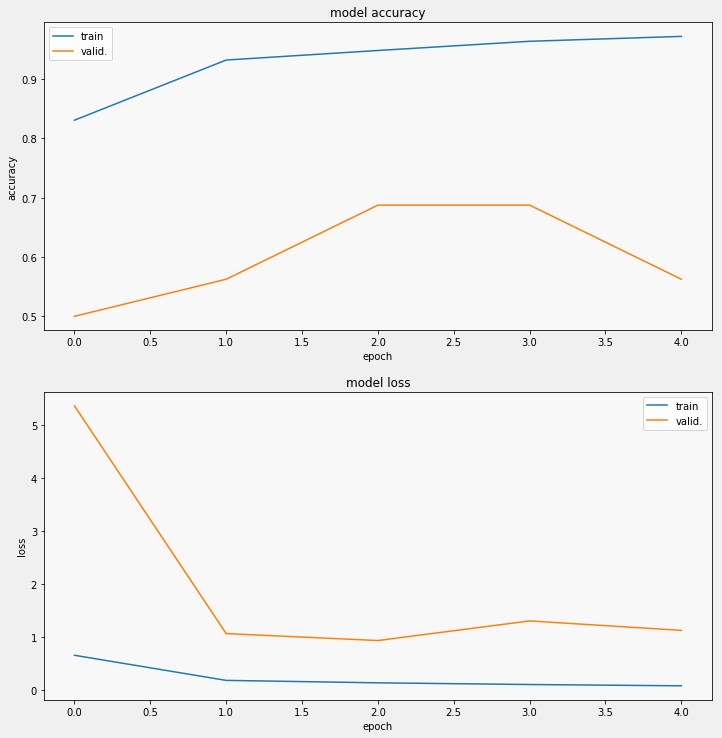

In [80]:
display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'accuracy', 211)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)